<a href="https://colab.research.google.com/github/codeguy186/ML-and-DL/blob/main/MNIST_GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time


In [ ]:
(train_images,train_labels),(test_images,test_labels)=tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


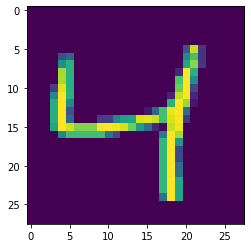

In [ ]:
plt.imshow(train_images[2])

In [ ]:
train_images=train_images.reshape(train_images.shape[0],28,28,1)

In [ ]:
train_images=(train_images-127.5)/127.5

In [ ]:
#splitting to smaller slices and shuffle
BUFFER_SIZE=train_images.shape[0]
BATCH_SIZE=100
train=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
#MAKING DISCRIMINATOR MODEL
def make_discriminator():
  model=tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(7,(3,3),padding="same",input_shape=(28,28,1)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dense(50,activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  return model

In [ ]:
disc=make_discriminator()

In [ ]:
disc(np.random.rand(1,28,28,1).astype('float32'))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.14935662]], dtype=float32)>

In [ ]:
disc_opt=tf.optimizers.Adam(1e-3)

In [ ]:
#making loss fn for disc
def disc_loss(real,fake):
  real=tf.sigmoid(real)
  fake=tf.sigmoid(fake)
  real_loss=tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real),real)#comparing all ones tensor to real predictions tensor
  fake_loss=tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake),fake)#comparing all zeros tensor to fake predictions tensor
  return fake_loss+real_loss



In [ ]:
#MAKING GENERATOR MODEL
def make_generator():
  model=tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256,input_shape=(100,)))
  model.add(tf.keras.layers.BatchNormalization())#scales outputs to prevent overfitting or explosion and to normalize
  model.add(tf.keras.layers.Reshape((7,7,256)))
  model.add(tf.keras.layers.Conv2DTranspose(128,(3,3),padding="same"))#transpose of convolution is deconvolution
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding="same"))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(1,(3,3),strides=(2,2),padding="same"))
  return model


In [ ]:
gen=make_generator()

In [ ]:
gen_opt=tf.optimizers.Adam(1e-4)

In [ ]:
def gen_loss(fake):
  fake=tf.sigmoid(fake)
  fake_loss=tf.losses.binary_crossentropy(tf.ones_like(fake),fake)#ones because we want original like fake images
  return fake_loss

In [ ]:
#single training
def train_step(images):
  fake_image_noise=np.random.randn(BATCH_SIZE,100).astype('float32')
  with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
    generated_images=gen(fake_image_noise)#outputs fake generated images
    real_images=disc(images)
    fake_images=disc(generated_images)
    gloss=gen_loss(fake_images)
    dloss=disc_loss(real_images,fake_images)

    gradientg=gen_tape.gradient(gloss,gen.trainable_variables)
    gradientd=disc_tape.gradient(dloss,disc.trainable_variables)

    gen_opt.apply_gradients(zip(gradientg,gen.trainable_variables))
    disc_opt.apply_gradients(zip(gradientd,disc.trainable_variables))

    print("gen loss:",np.mean(gloss))
    print("disc loss:",np.mean(dloss))

In [ ]:
#TRAINING batches
def train_model(dataset,epochs):
  for _ in range(epochs):
    for images in dataset:
      images=tf.cast(images,tf.dtypes.float32)
      train_step(images)

In [ ]:
train_model(train,5)

Streaming output truncated to the last 5000 lines.
gen loss: 3.445679
disc loss: 0.13941818
gen loss: 3.8060455
disc loss: 0.17281407
gen loss: 3.423387
disc loss: 0.14377095
gen loss: 3.3028371
disc loss: 0.15278406
gen loss: 3.468651
disc loss: 0.20990503
gen loss: 3.227168
disc loss: 0.20420125
gen loss: 3.5039682
disc loss: 0.20168567
gen loss: 3.59682
disc loss: 0.22123152
gen loss: 3.514706
disc loss: 0.17598024
gen loss: 3.1020849
disc loss: 0.24502788
gen loss: 3.166566
disc loss: 0.21363883
gen loss: 3.3392785
disc loss: 0.14712162
gen loss: 3.822377
disc loss: 0.21785855
gen loss: 3.4593692
disc loss: 0.19720194
gen loss: 2.7767136
disc loss: 0.21741036
gen loss: 3.0057569
disc loss: 0.165447
gen loss: 2.8627534
disc loss: 0.17500257
gen loss: 3.0377302
disc loss: 0.16138962
gen loss: 3.7362347
disc loss: 0.24405618
gen loss: 3.35227
disc loss: 0.24538028
gen loss: 2.7992568
disc loss: 0.1465164
gen loss: 2.7754462
disc loss: 0.15161349
gen loss: 2.7442968
disc loss: 0.163851

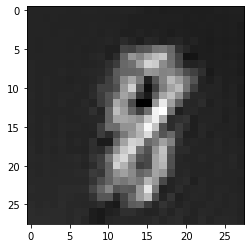

In [21]:
plt.imshow(tf.reshape(gen(np.random.randn(1,100)),(28,28)),cmap='gray')
